In [10]:
import numpy as np
import nengo
import sklearn.datasets
%matplotlib inline
import matplotlib.pyplot as plt

n_training = 5000
t_image = 0.1   # time to present each image for
use_gabor = True
n_neurons = 500
n_testing = 100
dt = 0.001

mnist = sklearn.datasets.fetch_mldata('MNIST original')

x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

model = nengo.Network()
with model:
    def stim_func(t, data=x[n_training:]):
        index = int(t / t_image)
        return data[index % len(data)]
    stim = nengo.Node(stim_func)

    if use_gabor:
        from nengo_extras.vision import Gabor, Mask
        encoders = Gabor().generate(n_neurons, (11, 11))
        encoders = Mask((28, 28)).populate(encoders, flatten=True)
    else:
        encoders = nengo.dists.UniformHypersphere(surface=True)

    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=784,
                         encoders=encoders,
                         intercepts=nengo.dists.CosineSimilarity(784+2))

    def result_func(t, raw, correct=y[n_training:]):
        index = int((t-dt) / t_image)
        c = np.argmax(correct[index])
        r = np.argmax(raw)
        return np.hstack([raw, c, r])
    result = nengo.Node(result_func, size_in=10)

    nengo.Connection(stim, ens, synapse=None)
    c = nengo.Connection(ens, result,
                         eval_points=x[:n_training],
                         function=y[:n_training],
                         synapse=0.02)

    p_output = nengo.Probe(result)

c:\users\terry\py3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\terry\py3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
sim = nengo.Simulator(model)
with sim:
    sim.run(n_testing*t_image)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

(0, 2.0)

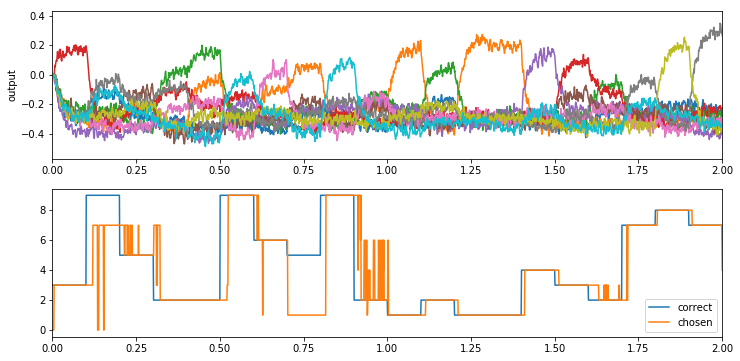

In [17]:
correct = sim.data[p_output][:,10].astype(int)
result = sim.data[p_output][:,11].astype(int)
confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)
times = sim.trange()
for i in range(n_testing):
   t = (i + 1) * t_image
   index = np.argmax(times >= t) - 1
   count[correct[index]] += 1
   confusion[correct[index],result[index]] += 1

score = sum(confusion[i, i] for i in range(10)) / float(n_testing)

plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_output][:,:10])
plt.xlim(0, t_image * min(n_testing, 20))
plt.ylabel('output')
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_output][:,10:])
plt.legend(['correct', 'chosen'], loc='best')
plt.xlim(0, t_image * min(n_testing, 20))

In [18]:
print(confusion)

[[ 7  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  1  0  1  1]
 [ 0  1  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 0  3  0  0  0  6  0  0  0  0]
 [ 0  1  0  0  0  0  9  0  0  0]
 [ 0  1  0  0  0  0  0  8  0  0]
 [ 0  2  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  1  0  6]]
